# Выбор локации для скважины

***Описание проекта:*** 
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов.

*Шаги для выбора локации:*

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Цель исследования:***
Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, и проанализировать возможную прибыль и риски техникой *Bootstrap.*

***Условия задачи:***
1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

***Описание данных:***

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv;
- /datasets/geo_data_1.csv;
- /datasets/geo_data_2.csv.

В них представлены следующие признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине в тыс. баррелей, целевой признак.



***Краткий ход исследования***

1. Загрузить и подготовить данные;

2. Обучить и выполнить проверку модели;

3. Подготовиться к расчёту прибыли;

4. Рассчитать прибыли и риски.

## Загрузка и подготовка данных

Сначала установим необходимые библиотеки:

In [1]:
!pip install -q phik
!pip install -q scikit-learn --upgrade

Далее импортируем библиотеки, необходимые для работы:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import phik
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Считываем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы. Пути к файлам:
- /datasets/geo_data_0.csv - geo_0;
- /datasets/geo_data_1.csv - geo_1;
- /datasets/geo_data_2.csv - geo_2.

Поменяем базовые индексы в датафрейме — сделаем индексами колонку 'id':

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_0 = geo_0.set_index('id')

geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_1 = geo_1.set_index('id')

geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_2 = geo_2.set_index('id')

Проверим, что данные в таблицах соответствуют описанию. Выведем по одной случайной строке всех датафреймов:

In [4]:
geo_0.sample(1)

,f0,f1,f2,product
id,,,,
4NM34,0.230488,-0.509237,0.800252,120.891579


In [5]:
geo_1.sample(1)

,f0,f1,f2,product
id,,,,
5Xvdj,-11.074229,-5.742911,3.004974,84.038886


In [6]:
geo_2.sample(1)

,f0,f1,f2,product
id,,,,
Dky4A,3.240938,4.286884,9.770059,140.558504


*Таким образом, представленные исходные данные соответствуют описанию.*

Далее проведём предобработку данных.

Для начала создадим  2 функции: 
- data_main_info, которая будет выводить общую информацию о каждом датафрейме с помощью методов: info() и head();
- data_preprocessing, которая будет определять количество пропущенных значений в каждом столбце и искать явные дубликаты:

In [7]:
def data_main_info(data):
       
    print(f'Общая информация:') 
    print(data.info())
    print()
    print(f'Первые пять строк таблицы:')
    display(data.head())

In [8]:
def data_preprocessing(data):
    print(f'Количество пропущенных значений в каждом столбце:')
    print(data.isna().sum())
    print()   
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

Рассмотрим общую информацию о каждом датафрейме:

In [9]:
data_main_info(geo_0)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None

Первые пять строк таблицы:


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


В данных по первому региону имеется 100000 строк и 4 столбца, а все типы данных соответствуют содержимому.

Проверим данные на наличие пропусков и дубликатов:

In [10]:
data_preprocessing(geo_0)

Количество пропущенных значений в каждом столбце:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0


В датафрейме отсутствуют строки-дубликаты и пропущенные значения.

Проверим данные на наличие неявных дубликатов, вызвав метод nunique():

In [11]:
geo_0.nunique()

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Неявные дубликаты в датафрейме geo_0 отсутствуют.

Проделаем аналогичные действия с geo_1 и geo_2:

In [12]:
data_main_info(geo_1)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None

Первые пять строк таблицы:


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


Здесь также имеется 100000 строк и 4 столбца, и все типы данных соответствуют содержимому.

Проверим geo_1 на наличие пропусков и дубликатов:

In [13]:
data_preprocessing(geo_1)

Количество пропущенных значений в каждом столбце:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0


Аналогично пропуски и явные дубликаты отсутствуют.

Проверим наличие неявных дубликатов:

In [14]:
geo_1.nunique()

f0         100000
f1         100000
f2         100000
product        12
dtype: int64

В данном случае во входных признаках по-прежнему отсутствуют неявные дубликаты, а вот целевой признак содержит всего 12 уникальных значений, которые дублируются в 100000 строк. Посмотрим, какие это уникальные значения:

In [15]:
geo_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

То есть у данных по второму региону величины объёма запасов сырья принимают только эти 12 дискретных значений. В реальной жизни такое вряд ли имеет место, но поскольку данные синтетические, оставим всё без изменений и будем считать, что такая ситуация имеет право на существование.

Осталось изучить информацию о третьем регионе (geo_2):

In [16]:
data_main_info(geo_2)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None

Первые пять строк таблицы:


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Как и в предыдущих случаях, 100000 строк и 4 столбца, а типы данных соответсвуют содержимому.

Посмотрим наличие пропущенных значений и явных дубликатов:

In [17]:
data_preprocessing(geo_2)

Количество пропущенных значений в каждом столбце:
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0


Аналогичным образом, пропуски и строки-дубликаты отсутствуют.

Проверим на неявные дубликаты: 

In [18]:
geo_2.nunique()

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Как и в случае geo_0 здесь нет неявных дубликатов.

*Таким образом, в результате предобработки данных:* 
- пропущенные значения и строки-дубликаты отсутствуют во всех датафреймах;
- неявные дубликаты, которые были оставлены нетронутыми, присутствуют только в данных geo_1;
- типы данных соответствуют содержимому столбцов. 

Проведём исследовательский анализ данных из каждой таблицы.

Начнём с изучения статистики в geo_0. Вызовем метод describe:

In [19]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Видно, что во всех столбцах средние и медианные значения различаются незначительно, что говорит о симметричном распределении данных в них и будет проверено в дальнейшем.

Построим графики для каждого признака и подробнее изучим каждый из них.

Начнём со столбца 'f0': построим гистограмму и диаграмму размаха:

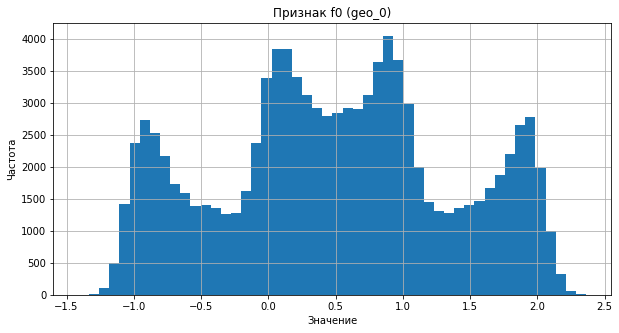

In [20]:
plt.figure(figsize=(10, 5))

geo_0['f0'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f0 (geo_0)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

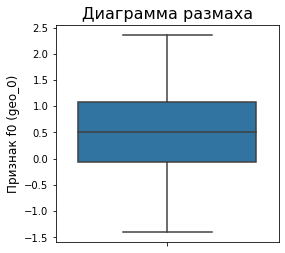

In [21]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_0,y='f0');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f0 (geo_0)", fontsize=12);

Как можно видеть, выбросы в распределении величины 'f0' отсутствуют, а данные симметричны относительно 0.5. Однако распределение не имеет характер нормального, и присутствует 4 пика, так как данные синтетические.

Рассмотрим признак 'f1':

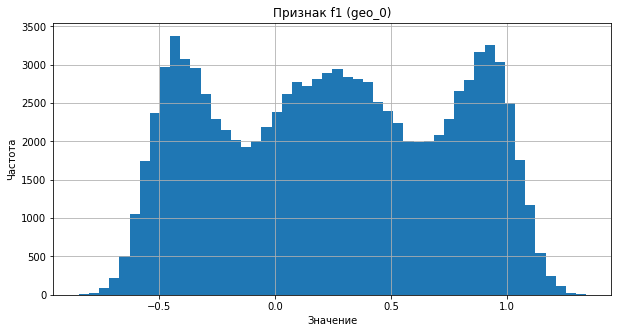

In [22]:
plt.figure(figsize=(10, 5))

geo_0['f1'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f1 (geo_0)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

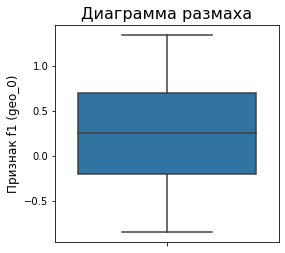

In [23]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_0,y='f1');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f1 (geo_0)", fontsize=12);

Ситуация аналогичная: распределение не нормальное, но симметричное, только уже относительно 0.25, имеется 3 пика, выбросов нет.

Остаётся признак 'f2':

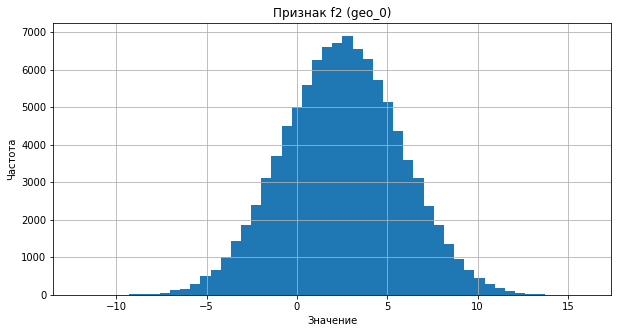

In [24]:
plt.figure(figsize=(10, 5))

geo_0['f2'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f2 (geo_0)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

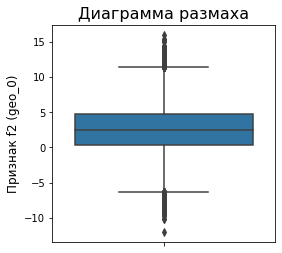

In [25]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_0,y='f2');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f2 (geo_0)", fontsize=12);

Здесь уже распределение имеет нормальный вид и симметрично относительно 2.5. Выбросы присутствуют как в области малых значений (примерно меньше -6), так и в области больших (примерно больше 11).

Посмотрим на распределение целевого признака в geo_0:

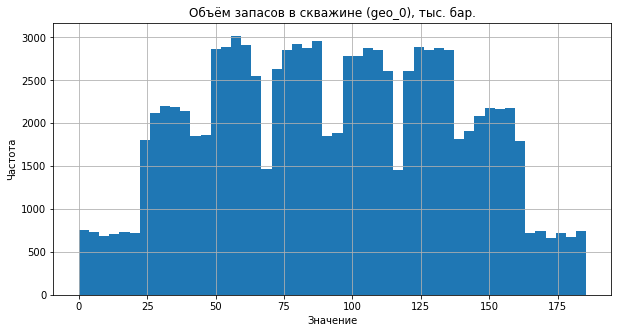

In [26]:
plt.figure(figsize=(10, 5))

geo_0['product'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Объём запасов в скважине (geo_0), тыс. бар.')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

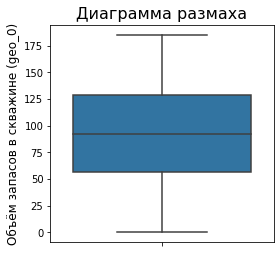

In [27]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_0,y='product');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём запасов в скважине (geo_0)", fontsize=12);

Распределение не имеет нормальный вид, данные симметричны относительно 92 тыс. баррелей, выбросы отсутствуют. Отчётливо дифференцируются области высоких и низких значений.

Наконец, проведём небольшой корреляционный анализ признаков. Изучим взаимосвязь между признаками, построив матрицу корреляции с помощью метода Phik:

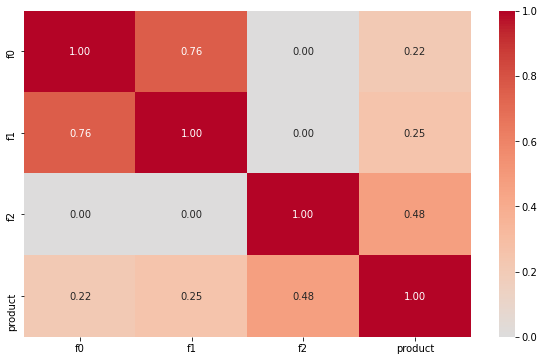

In [28]:
plt.figure(figsize=(10, 6));

sns.heatmap(
    geo_0.phik_matrix(
       interval_cols=['f0', 'f1', 'f2', 'product']
   ),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f'
);

Как можно видеть, высокая корреляция наблюдается между входными признаками 'f0' и 'f1', причём целевой признак коррелирует с входными менее чем на 0.5, а мультиколлинеарность отсутствует (коэффициент корреляции должен быть не менее 0.9).

Перейдём к анализу geo_1:

In [29]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Как можно видеть, средние и медианные значения признаков 'f0' и 'f1' довольно близки, а вот для 'f2' и 'product' различия уже существенны, что может говорит о наличии выбросов.

Построим графики для каждого признака и подробнее изучим каждый из них.

Вновь начнём с 'f0': построим гистограмму и диаграмму размаха:

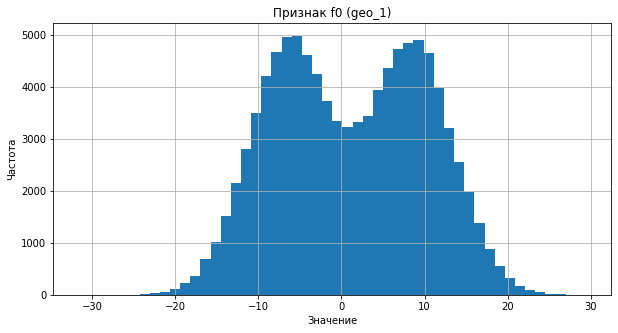

In [30]:
plt.figure(figsize=(10, 5))

geo_1['f0'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f0 (geo_1)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

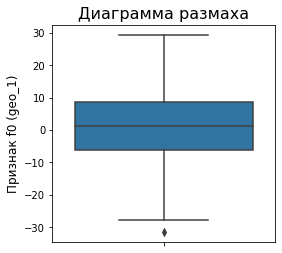

In [31]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_1,y='f0');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f0 (geo_1)", fontsize=12);

Данные как будто имеют вид двух нормальных распределений, объединённых в области 0, относительно которого суммарное распределение симметрично. В области -30 присутствует выброс, посмотрим на него:

In [32]:
geo_1.query('f0 <= -30')

,f0,f1,f2,product
id,,,,
jJm67,-31.609576,1.390042,4.001055,110.992147


Выброс действительно только один, оставим его.

Перейдём к f1:

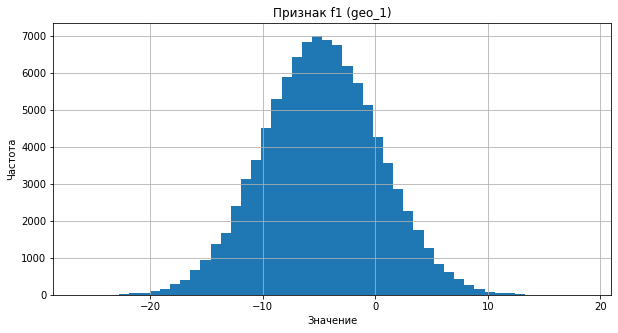

In [33]:
plt.figure(figsize=(10, 5))

geo_1['f1'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f1 (geo_1)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

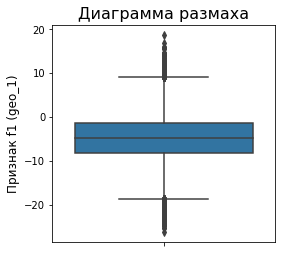

In [34]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_1,y='f1');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f1 (geo_1)", fontsize=12);

Данные имеют вид нормального распределения, симметричного относительно -4.8, с выбросами на нижнем и на верхнем пределах.

Далее изучим признак f2:

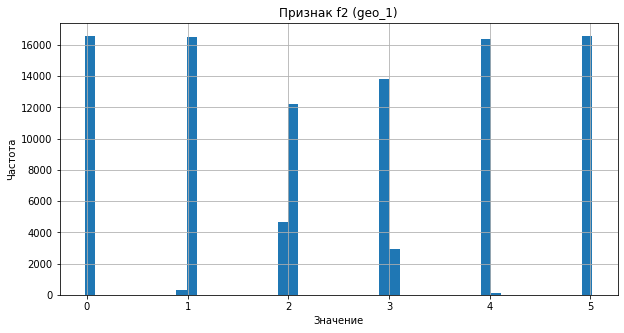

In [35]:
plt.figure(figsize=(10, 5))

geo_1['f2'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f2 (geo_1)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

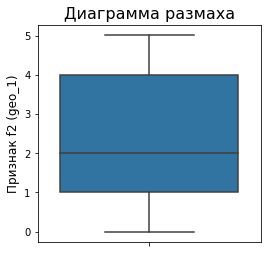

In [36]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_1,y='f2');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f2 (geo_1)", fontsize=12);

Как можно видеть, в данном случае признак 'f2' принимает 100000 уникальных значений, которые дискретно и достаточно равномерно распределены в области от 0 до 5 включительно, через единицу, т.е. в среднее значение находится на уровне 2.5, при этом медианное - в области 2.

Изучим целевой признак в geo_1. Как мы помним из предобработки данных, здесь 'product' принимает только 12 уникальных значений, поэтому вместо гистограммы построим горизонтальную столбчатую диаграмму:

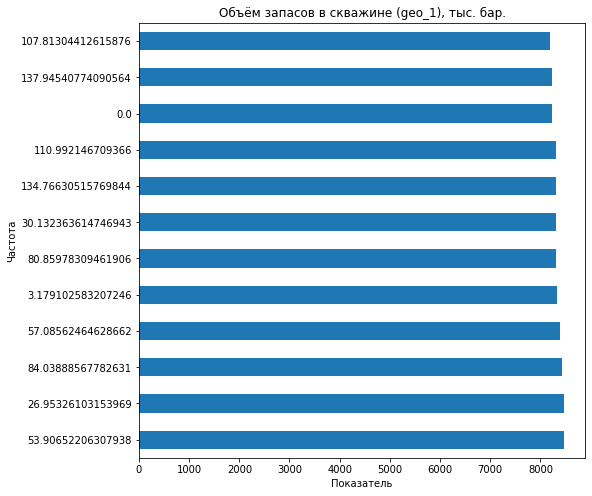

In [37]:
plt.figure(figsize=(8, 8))

geo_1['product'].value_counts().plot(
    kind='barh',
    rot=0
);
plt.title('Объём запасов в скважине (geo_1), тыс. бар.')
plt.xlabel("Показатель")
plt.ylabel("Частота")
plt.show();

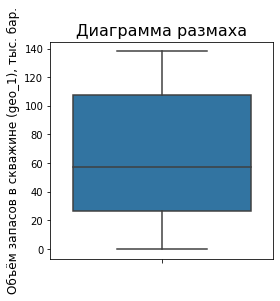

In [38]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_1,y='product');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём запасов в скважине (geo_1), тыс. бар.", fontsize=12);

Видно, что наиболее часто объём запасов сырья имеет значение почти 54 тыс. баррелей, при этом в среднем - это почти 69 тыс. бар., а медианное значение - на уровне 57 тыс. бар.

Также проведём корреляционный анализ с помощью метода Phik:

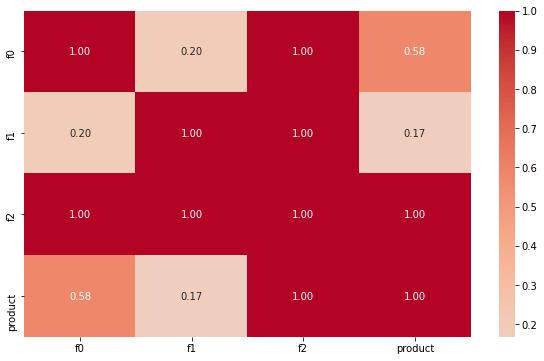

In [43]:
plt.figure(figsize=(10, 6));

sns.heatmap(
    geo_1.phik_matrix(
       interval_cols=['f0', 'f1']
   ),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f'
);

Наблюдается интересная картина: признак 'f2', который не имеет непрерывного распределения, полностью коррелирует, как с остальными входными признаками, так и с целевым. Налицо наличие мультиколлинеарности, что говорит о необходимости удаления 'f2' из geo_1. Однако следует помнить, что данные синтетические, а все признаки 'f0', 'f1' и 'f2' являются значимыми, а значит, ничего удалять не будем (проверено: удаление признака 'f2' из geo_1 приводит к отрицательным значениям прибыли и 100 % риску убытков, т.е. ни один из регионов не удовлетворяет условиям отбора).

Наконец, исследуем geo_2:

In [40]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


По аналогии с geo_0 здесь средние и медианные значения приблизительно одинаковы, что говорит о симметричном распределении данных в них и будет проверено в дальнейшем.

Построим графики для каждого признака и подробнее изучим каждый из них.

Начнём со столбца 'f0': построим гистограмму и диаграмму размаха:

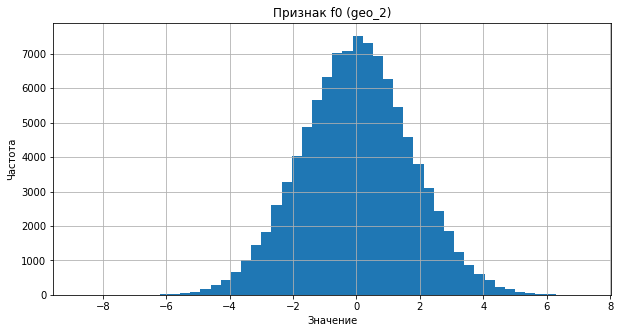

In [41]:
plt.figure(figsize=(10, 5))

geo_2['f0'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f0 (geo_2)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

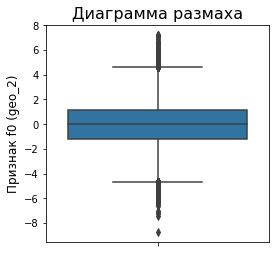

In [42]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_2,y='f0');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f0 (geo_2)", fontsize=12);

Величины в 'f0' распределены равномерно и симметрично относительно 0. Выбросы имеются к слева, так и справа от среднего значения.

Изучим 'f1':

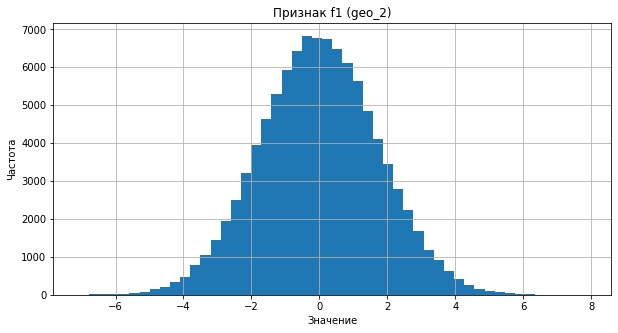

In [43]:
plt.figure(figsize=(10, 5))

geo_2['f1'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f1 (geo_2)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

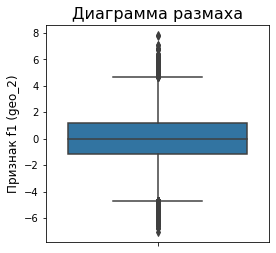

In [44]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_2,y='f1');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f1 (geo_2)", fontsize=12);

Картина практически аналогична предыдущему признаку, т.е. 'f0'.

Теперь рассмотрим 'f2':

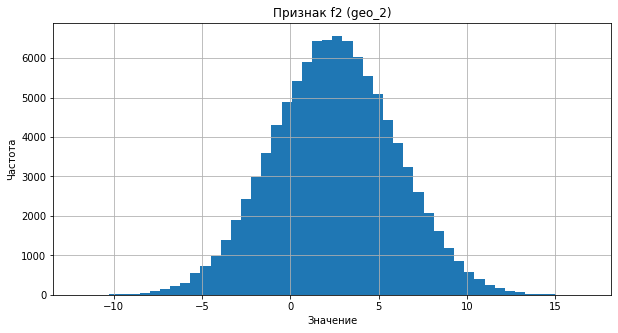

In [45]:
plt.figure(figsize=(10, 5))

geo_2['f2'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Признак f2 (geo_2)')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

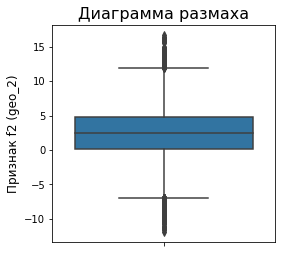

In [46]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_2,y='f2');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Признак f2 (geo_2)", fontsize=12);

И в данном случае распределение имеет нормальный вид, симметрично относительно 2.5, а выбросы также расположены с обеих сторон.

Проанализируем целевой признак в geo_2:

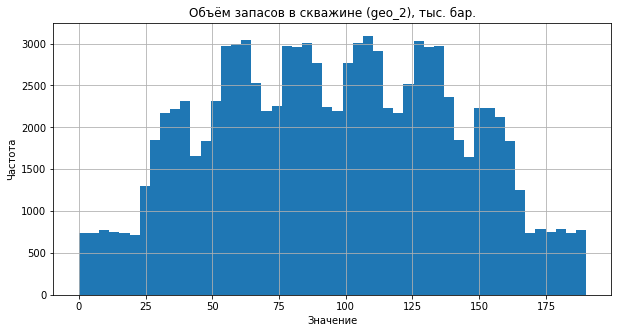

In [47]:
plt.figure(figsize=(10, 5))

geo_2['product'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Объём запасов в скважине (geo_2), тыс. бар.')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

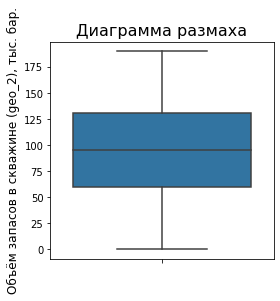

In [48]:
plt.figure(figsize=(4,4));

sns.boxplot(data=geo_2,y='product');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём запасов в скважине (geo_2), тыс. бар.", fontsize=12);

Как можно видеть, по аналогии с geo_0, величина 'product' не имеет вид нормального распределения, при этом симметрична относительно 95 тыс. баррелей, а области относительно высоких и низких значений отчётливо дифференцируются и чередуются.

Остаётся провести корреляционный анализ:

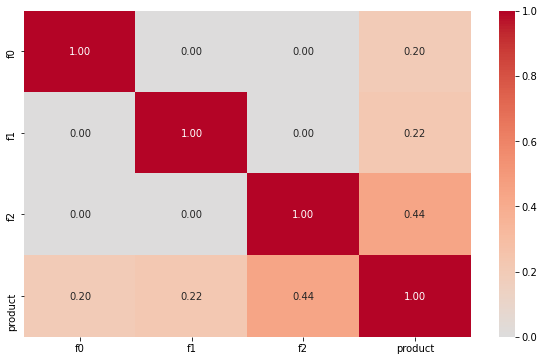

In [49]:
plt.figure(figsize=(10, 6));

sns.heatmap(
    geo_2.phik_matrix(
       interval_cols=['f0', 'f1', 'f2', 'product']
   ),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f'
);

Между входными признаками корреляция отсутствует, а целевой признак незначительно коррелирует (менее 0.5) с входными.

*Таким образом, был проведён исследовательский анализ данных, в результате которого было определено следующее:*

1. Для региона geo_0:
- признаки 'f0' и 'f1' не имеют вид нормального распределения, при этом симметричны относительно средних значений, имеют пиковые области (4 и 3 соответственно) высоких значений, выбросы отсутствуют;
- признак 'f2' распределён нормально и симметрично, при этом имеются выбросы;
- целевой признак 'product' также не имеет вид нормального распределения, симметричен и не имеет выбросов, причём на графике отчётливо дифференцируются области высоких и низких значений;
- корреляция методом Phik выявила высокую корреляцию между входными признаками 'f0' и 'f1', а мультиколлинеарность отсутствует (коэффициент корреляции должен быть не менее 0.9).

2. Для региона geo_1:
- признак 'f0' имеет вид симметричного распределения с двуми нормального вида пиками и одним выбросом;
- признак 'f1' распределён нормально и симметрично, при этом имеются выбросы;
- признак 'f2' принимает 100000 уникальных значений, которые дискретно распределены между 0, 1, 2, 3, 4 и 5 включительно;
- целевой признак 'product' принимает только 12 уникальных значений, причём наиболее часто -  почти 54 тыс. баррелей, в среднем - это почти 69 тыс. бар., а медиана - на уровне 57 тыс. бар.;
- корреляция методом Phik показала, что признак 'f2' на 100 % линейно коррелирует со всеми остальными признаками, т.е. наблюдается мультиколлинеарности, однако это не говорит о необходимости его удаления из датафрейма, поскольку данные синтетические, а все входные признаки являются значимыми.

3. Для региона geo_2:
- признаки 'f0','f1' и 'f2' имеют вид нормального распределения, симметричны и имеют выбросы с обеих сторон от среднего значения;
- целевой признак 'product' также не имеет вид нормального распределения, симметричен и не имеет выбросов, причём на графике отчётливо дифференцируются области высоких и низких значений;
- корреляция методом Phik не выявила корреляции между входными признаками, а мультиколлинеарность отсутствует (коэффициент корреляции должен быть не менее 0.9).

## Обучение и проверка модели

Разобьём данные на обучающую и валидационную выборки в соотношении 75:25, создав для этого функцию data_split, чтобы потом применить её к каждому датафрейму:

In [50]:
#Зафиксируем RANDOM_STATE и размер выборок:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Создадим функцию:
def data_split(df):
#Разделим данные по входным и целевому признакам:
    X = df.drop(['product'], axis=1)
    y = df['product']
#Получим тренировочную и валидационную выборки с помощью train_test_split:
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE
    )
#На выходе функции вернём полученные выборки:    
    return X_train, X_val, y_train, y_val

Применим получившуюся функцию к каждому региону и выведем на экран размеры выборок с входными признаками:

In [51]:
X_train_0, X_val_0, y_train_0, y_val_0 = data_split(geo_0)

print(X_train_0.shape, X_val_0.shape)

X_train_1, X_val_1, y_train_1, y_val_1 = data_split(geo_1)

print(X_train_1.shape, X_val_1.shape)

X_train_2, X_val_2, y_train_2, y_val_2 = data_split(geo_2)

print(X_train_2.shape, X_val_2.shape)

(75000, 3) (25000, 3)
(75000, 3) (25000, 3)
(75000, 3) (25000, 3)


Для масштабирования количественных признаков создадим две переменные, передав им RobustScaler() - для регионов geo_0 и geo_1, где не все признаки распределены нормально, и StandardScaler() - для региона geo_2:

In [52]:
rob_scaler = RobustScaler()

stand_scaler = StandardScaler()

Проведём масштабирование тренировочной и валидационной выборок для всех регионов:

In [53]:
X_train_0 = rob_scaler.fit_transform(X_train_0)
X_val_0 = rob_scaler.transform(X_val_0)

X_train_1 = rob_scaler.fit_transform(X_train_1)
X_val_1 = rob_scaler.transform(X_val_1)

X_train_2 = stand_scaler.fit_transform(X_train_2)
X_val_2 = stand_scaler.transform(X_val_2)

Для каждого региона обучим модель и сделаем предсказания на валидационной выборке. При этом сохраним предсказания и правильные ответы на валидационной выборке. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

Для этого создадим функцию predictions:

In [54]:
def predictions(X_train, X_val, y_train, y_val):
#Инициализируем модель линейной регресии:
    model_lr  = LinearRegression()
#Обучим модель на тренировочных данных:
    model_lr.fit(X_train, y_train)
#Сделаем предсказания и рассчитаем необходимые метрики на валидационной выборке:
    y_val_pred = model_lr.predict(X_val)
    mean = y_val_pred.mean()
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    residuals = y_val - y_val_pred
#Вернём предсказания и рассчитанные метрики:    
    return y_val_pred, mean, rmse, residuals

Получим предсказания, средний запас сырья, RMSE и остатки для каждого региона:

In [55]:
y_val_pred_0, mean_0, rmse_0, residuals_0 = predictions(X_train_0, X_val_0, y_train_0, y_val_0)

y_val_pred_1, mean_1, rmse_1, residuals_1 = predictions(X_train_1, X_val_1, y_train_1, y_val_1)

y_val_pred_2, mean_2, rmse_2, residuals_2 = predictions(X_train_2, X_val_2, y_train_2, y_val_2)

Создадим таблицу model_results с результатами моделирования:

In [56]:
#Создадим список с названиями колонок будущей таблицы:
cols = [
    'Метрика RMSE на валидационной выборке',
    'Средний запас сырья, тыс. бар.'
]

#Создадим список списков с величинами, которые будут в таблице:
metrics = [
    [round(rmse_0, 3), round(mean_0, 3)],
    [round(rmse_1, 3), round(mean_1, 3)],
    [round(rmse_2, 3), round(mean_2, 3)]
]

#Создадим датафрейм:
model_results = pd.DataFrame(data=metrics, columns=cols)
#Передадим датафрейму в качестве индексов названия регионов:
model_results.index = ['Регион geo_0', 'Регион geo_1', 'Регион geo_2']

model_results

,Метрика RMSE на валидационной выборке,"Средний запас сырья, тыс. бар."
Регион geo_0,37.757,92.399
Регион geo_1,0.890,68.713
Регион geo_2,40.146,94.771


Как можно видеть, наиболее качественно модель сработала для региона geo_1, где корено среднеквадратичной ошибки - наименьший. Однако для этого региона средний предсказанный запас сырья почти на 1/3 меньше, чем для других регионов: почти 69 против 92-95 тыс. баррелей.

Проверим качество модели, проанализировав остатки:

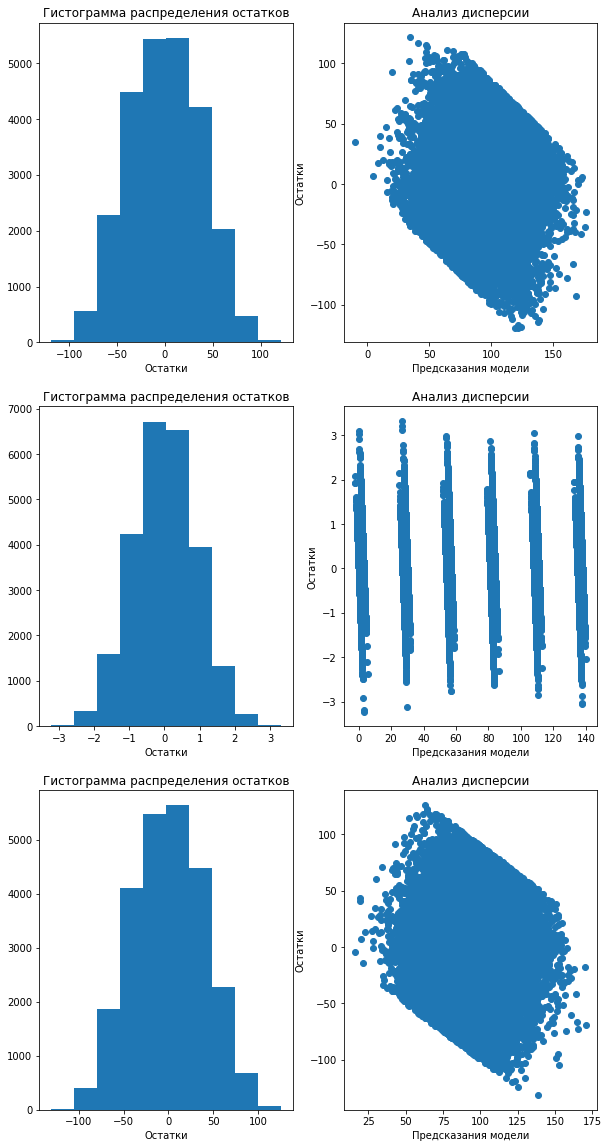

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(10, 20))

axes[0, 0].hist(x=residuals_0)
axes[0, 0].set_title('Гистограмма распределения остатков')
axes[0, 0].set_xlabel('Остатки')

axes[1, 0].hist(x=residuals_1)
axes[1, 0].set_title('Гистограмма распределения остатков')
axes[1, 0].set_xlabel('Остатки')

axes[2, 0].hist(x=residuals_2)
axes[2, 0].set_title('Гистограмма распределения остатков')
axes[2, 0].set_xlabel('Остатки')

axes[0, 1].scatter(x=y_val_pred_0, y=residuals_0)
axes[0, 1].set_xlabel('Предсказания модели')
axes[0, 1].set_ylabel('Остатки')
axes[0, 1].set_title('Анализ дисперсии')

axes[1, 1].scatter(x=y_val_pred_1, y=residuals_1)
axes[1, 1].set_xlabel('Предсказания модели')
axes[1, 1].set_ylabel('Остатки')
axes[1, 1].set_title('Анализ дисперсии')


axes[2, 1].scatter(x=y_val_pred_2, y=residuals_2)
axes[2, 1].set_xlabel('Предсказания модели')
axes[2, 1].set_ylabel('Остатки')
axes[2, 1].set_title('Анализ дисперсии')


plt.show()

Анализ остатков показал, что они распределены нормально и график симметричен относительно нуля для каждого региона, однако диаграмма рассеяния остатков не имеет постоянный вид для регионов geo_0 и geo_2: с ростом предсказаний модели остатки становятся отрицательными. В случае же geo_1 дисперсия остатков постоянна для каждого предсказания модели. Это говорит о высокой предсказательной способности модели.

## Подготовка к расчёту прибыли

Подготовимся к расчёту прибыли. Все ключевые значения для расчётов сохраним в отдельных переменных:

In [58]:
budget = 10000000000
profit = 450000
n = 500
k = 200

Рассчитаем достаточный объём сырья (volume) для безубыточной разработки новой скважины:

In [59]:
volume = budget / 200 / profit

print('Достаточный для безубыточной разработки новой скважины объем сырья:', round(volume, 3))

Достаточный для безубыточной разработки новой скважины объем сырья: 111.111


Сравним полученный объём сырья со средним запасом в каждом регионе. Для этого создадим таблицу reserves_data:

In [60]:
#Создадим список с названием колонки будущей таблицы:
col = ['Средний запас в регионе, тыс. бар.']

#Создадим список списков с величинами, которые будут в таблице:
avg_reserves = [
    [round(geo_0['product'].mean(), 3)],
    [round(geo_1['product'].mean(), 3)],
    [round(geo_2['product'].mean(), 3)]
]

#Создадим датафрейм:
reserves_data = pd.DataFrame(data=avg_reserves, columns=col)

#Построим столбец со значениями нехватки в тыс.бар.:
reserves_data['Нехватка до достаточного объёма, тыс. бар.'] =\
round(volume, 3) - reserves_data['Средний запас в регионе, тыс. бар.'] 

#Передадим датафрейму в качестве индексов названия регионов:
reserves_data.index = ['Регион geo_0', 'Регион geo_1', 'Регион geo_2']

reserves_data

,"Средний запас в регионе, тыс. бар.","Нехватка до достаточного объёма, тыс. бар."
Регион geo_0,92.500,18.611
Регион geo_1,68.825,42.286
Регион geo_2,95.000,16.111


Наибольший средний запас нефти наблюдается в регионе geo_2, а наименьший - в geo_1. При этом во всех регионах этот показатель ниже достаточного объёма для безубыточной разработки новой скважины: для geo_2 не хватает примерно 16 тыс. баррелей в среднем.

*Таким образом, в результате подготовки к расчёту прибыли:*
- были введены константы, соответстующие условию задачи (budget, profit, n, k);
- был рассчитан достаточный объём запасов нефти для безубыточной разработки новой скважины на уровне примерно 111 тыс.баррелей;
- было проведено сравнение среднего запаса нефти в каждом регионе с достаточным объёмом и отмечена нехватка в каждом из случаев.

## Расчёт прибыли и рисков 

Напишите функцию Income для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [61]:
def income (target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count].sum()
    return selected * profit - budget

Выберем скважины с максимальными значениями предсказаний, просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитаем прибыль для полученного объёма сырья.

Для этого создадим таблицу best_200_data:

In [62]:
#Создадим список с названиями колонок будущей таблицы:
cols = [
    'Суммарный предсказанный запас сырья по 200 скважинам, тыс. бар.',
    'Предсказанная прибыль, млн. руб.'
]

#Создадим список списков с величинами, которые будут в таблице:
best_200 = [
    [round(np.sort(y_val_pred_0)[-200:].sum(), 3),
     round((np.sort(y_val_pred_0)[-200:].sum() * profit - budget) / 1000000, 3)],
    [round(np.sort(y_val_pred_1)[-200:].sum(), 3), 
     round((np.sort(y_val_pred_1)[-200:].sum() * profit - budget) / 1000000, 3)],
    [round(np.sort(y_val_pred_2)[-200:].sum(), 3), 
     round((np.sort(y_val_pred_2)[-200:].sum() * profit - budget) / 1000000, 3)]
]

#Создадим датафрейм:
best_200_data = pd.DataFrame(data=best_200, columns=cols)

#Передадим датафрейму в качестве индексов названия регионов:
best_200_data.index = ['Регион geo_0', 'Регион geo_1', 'Регион geo_2']

best_200_data

,"Суммарный предсказанный запас сырья по 200 скважинам, тыс. бар.","Предсказанная прибыль, млн. руб."
Регион geo_0,30881.463,3896.658
Регион geo_1,27748.751,2486.938
Регион geo_2,29728.848,3377.982


Так, наибольший суммарный предсказанный запас сырья по наиболее перспективным скважинам отмечен для региона geo_0 - почти 31 миллион баррелей, и, соответственно, в этом случае и предсказанная прибыль наибольшая - около 3.9 миллиардов рублей. Наихудшие показатели отмечены для региона geo_1 с предсказаниями в почти 28 миллионами баррелей нефти и 2.5 миллиардами рублей прибыли.

Посчитаем риски и прибыль для каждого региона. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Для этого создадим функцию распределения прибыли income_dist:

In [63]:
#Создадим объект RandomState() из модуля numpy.random:
state = np.random.RandomState(12345)

#Определим функцию income_dist:
def income_dist(y_val, y_val_pred):

#Сделаем предсказания модели на валидационной выборке объектом Series:
    y_val_pred = pd.Series(y_val_pred, index=y_val.index)

#Создадим пустой список values, куда будут передаваться значения прибыли,\
#а также зададим переменную risk, которая в начале будет равна нулю: 
    values = []
    risk = 0
#Применим технику bootstrap с 1000 подвыборок для расчёта распределения прибыли:
    for i in range(1000):
        target_subsample = y_val.sample(n=n, replace=True, random_state=state)
        probs_subsample = y_val_pred[target_subsample.index]
        res = income(target_subsample, probs_subsample, k)
        values.append(res)
#В рамках каждой из 1000 итераций к переменной risk будем прибавлять 1,\
#если прибыль получилась отрицательной        
        if res < 0:
            risk += 1
#Сделаем список values объектом Series:        
    values = pd.Series(values)
#Рассчитаем среднюю прибыль, нижний и верхний пределы доверительного интервала и риск убытков:    
    mean = round(values.mean() / 1000000, 3)
    lower = round(values.quantile(0.025) / 1000000, 3)
    upper = round(values.quantile(0.975) / 1000000, 3)
    risk_rel = risk / 1000 * 100
    
#Вернём список рассчитанных величин:
    return [mean, lower, upper, risk_rel]

Подставим в эту функцию величины для каждого региона и создадим таблицу profit_data с результатами работы функции income_dist:

In [64]:
#Создадим список с названиями колонок будущей таблицы:
cols = [
    'Средняя предсказанная прибыль, млн. руб.',
    'Нижняя граница дов. интервала, млн. руб.',
    'Верхняя граница дов. интервала, млн. руб.',
    'Риск убытков, %'
]

#Создадим список списков с величинами, которые будут в таблице:
avg_profit = [
    income_dist(y_val_0, y_val_pred_0),
    income_dist(y_val_1, y_val_pred_1),
    income_dist(y_val_2, y_val_pred_2)
]

#Создадим датафрейм:
profit_data = pd.DataFrame(data=avg_profit, columns=cols)

#Передадим датафрейму в качестве индексов названия регионов:
profit_data.index = ['Регион geo_0', 'Регион geo_1', 'Регион geo_2']

profit_data

,"Средняя предсказанная прибыль, млн. руб.","Нижняя граница дов. интервала, млн. руб.","Верхняя граница дов. интервала, млн. руб.","Риск убытков, %"
Регион geo_0,435.934,-116.232,966.504,6.1
Регион geo_1,498.569,75.316,911.504,1.0
Регион geo_2,412.673,-158.940,978.191,7.0


*Таким образом, на основании полученных результатов можно сказать, что для разработки скважин наиболее целесообразно выбрать **регион geo_1**, где средняя прибыль по 200 наиболее перспективным скважинам предсказывается на уровне почти 500 миллионов рублей с наименьшим доверительным интервалом из рассчитанных: от 75 до 911 миллионов рублей. При этом риск убытков для этого региона оценивается на уровне 1.0 %, что укладывается в 2.5 % рисков по условию задачи.*